In [1]:
# @Time     : Jan. 02, 2019 22:17
# @Author   : Veritas YIN
# @FileName : main.py
# @Version  : 1.0
# @Project  : Orion
# @IDE      : PyCharm
# @Github   : https://github.com/VeritasYin/Project_Orion

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from os.path import join as pjoin

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

from matplotlib import pyplot as plt
from utils.math_graph import *
from data_loader.data_utils import *
from models.trainer import model_train
from models.tester import model_test
import datetime

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--n_route', type=int, default=228)
parser.add_argument('--n_his', type=int, default=12)
parser.add_argument('--n_pred', type=int, default=9)
parser.add_argument('--batch_size', type=int, default=50)
parser.add_argument('--epoch', type=int, default=50)
parser.add_argument('--save', type=int, default=10)
parser.add_argument('--ks', type=int, default=3)
parser.add_argument('--kt', type=int, default=3)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--opt', type=str, default='RMSProp')
parser.add_argument('--graph', type=str, default='default')
parser.add_argument('--inf_mode', type=str, default='merge')
parser.add_argument("-f", type=str, default="")

args = parser.parse_args()
print(f'Training configs: {args}')

n, n_his, n_pred = args.n_route, args.n_his, args.n_pred
Ks, Kt = args.ks, args.kt
# blocks: settings of channel size in st_conv_blocks / bottleneck design
blocks = [[1, 32, 64], [64, 32, 128]]

# Load wighted adjacency matrix W
if args.graph == 'default':
    #W = weight_matrix(pjoin('./dataset', f'PeMSD7_W_{n}.csv'))
    W = weight_matrix(pjoin('./dataset', f'W_{n}.csv'))
else:
    # load customized graph weight matrix
    W = weight_matrix(pjoin('./dataset', args.graph))

# Calculate graph kernel
L = scaled_laplacian(W)
# Alternative approximation method: 1st approx - first_approx(W, n).
Lk = cheb_poly_approx(L, Ks, n)
tf.add_to_collection(name='graph_kernel', value=tf.cast(tf.constant(Lk), tf.float32))

# Data Preprocessing
#data_file = f'PeMSD7_V_{n}.csv'
data_file = f'V_{n}.csv'
n_train, n_val, n_test = 34, 5, 5
PeMS = data_gen(pjoin('./dataset', data_file), (n_train, n_val, n_test), n, n_his + n_pred)
print(f'>> Loading dataset with Mean: {PeMS.mean:.2f}, STD: {PeMS.std:.2f}')

/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodr/code/env_oldtf/lib/python3.7/site-packages/tensorflow/python/f

Training configs: Namespace(batch_size=50, epoch=50, f='/home/rodr/.local/share/jupyter/runtime/kernel-d67aec84-334d-4a18-a91f-6c01e3dda0b5.json', graph='default', inf_mode='merge', ks=3, kt=3, lr=0.001, n_his=12, n_pred=9, n_route=228, opt='RMSProp', save=10)
>> Loading dataset with Mean: 58.50, STD: 13.73


In [2]:
data_seq = pd.read_csv('./dataset/V_228.csv', header=None).values
data_seq.shape

(12672, 228)

In [3]:
from workalendar.usa.california import CaliforniaSanFrancisco
holidays = [CaliforniaSanFrancisco().holidays(y) for y in [2012]][0]
holidays

[(datetime.date(2012, 1, 1), 'New year'),
 (datetime.date(2012, 1, 2), 'New year (Observed)'),
 (datetime.date(2012, 1, 16), 'Birthday of Martin Luther King, Jr.'),
 (datetime.date(2012, 2, 20), "Washington's Birthday"),
 (datetime.date(2012, 5, 28), 'Memorial Day'),
 (datetime.date(2012, 7, 4), 'Independence Day'),
 (datetime.date(2012, 9, 3), 'Labor Day'),
 (datetime.date(2012, 10, 8), 'Columbus Day'),
 (datetime.date(2012, 11, 11), 'Veterans Day'),
 (datetime.date(2012, 11, 12), 'Veterans Day (Observed)'),
 (datetime.date(2012, 11, 22), 'Thanksgiving Day'),
 (datetime.date(2012, 11, 23), 'Thanksgiving Friday'),
 (datetime.date(2012, 12, 25), 'Christmas Day')]

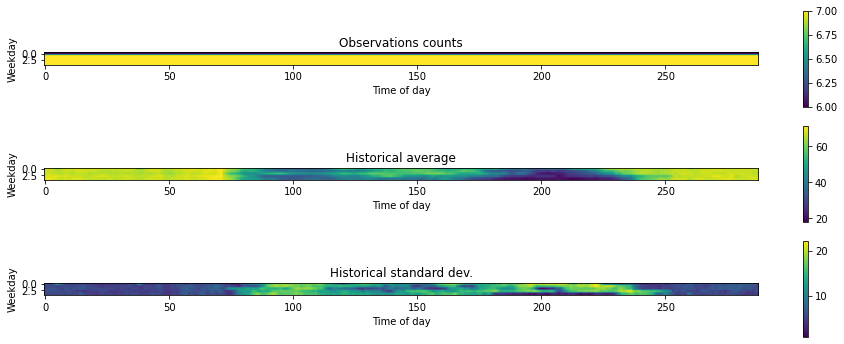

In [4]:
import sys
sys.path.append(os.path.abspath("/home/rodr/code/mobility-baselines"))
from mobility_detrender import MobilityDetrender
from evaluation import evaluation

detrender = MobilityDetrender(day_duration=12*24, week_duration=5)
trainset_len = n_train*12*24 # use only trainset for fitting historical averages
detrender.fit(data_seq[:trainset_len], start_date=datetime.date(2012,5,1), holidays=[])
detrender.visualize(0)

In [5]:
detrended_data = detrender.transform(data_seq, start_date=datetime.date(2012,5,1), holidays=[], mode='avg')
evl_train = evaluation(data_seq, detrender.ha_trend)
print('Residuals of Historical Average (on all data) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
detrended_data.shape

Residuals of Historical Average (on all data) -> MAPE: 0.090; MAE:  3.526; RMSE: 6.439


(12672, 228)

In [6]:
# train/val/test split
from data_loader.data_utils import seq_gen
n_route = n
n_frame = n_his + n_pred
day_slot = 288
seq_train = seq_gen(n_train, data_seq, 0, n_frame, n_route, day_slot)
seq_val = seq_gen(n_val, data_seq, n_train, n_frame, n_route, day_slot)
seq_test = seq_gen(n_test, data_seq, n_train + n_val, n_frame, n_route, day_slot)
print(seq_train.shape)
print(seq_val.shape)
print(seq_test.shape)
ha_train = seq_gen(n_train, detrender.ha_trend, 0, n_frame, n_route, day_slot)
ha_val = seq_gen(n_val, detrender.ha_trend, n_train, n_frame, n_route, day_slot)
ha_test = seq_gen(n_test, detrender.ha_trend, n_train + n_val, n_frame, n_route, day_slot)
print(ha_train.shape)
print(ha_val.shape)
print(ha_test.shape)

(9112, 21, 228, 1)
(1340, 21, 228, 1)
(1340, 21, 228, 1)
(9112, 21, 228, 1)
(1340, 21, 228, 1)
(1340, 21, 228, 1)


In [7]:
evl_val = evaluation(seq_val[:,n_his+n_pred-1,:,:], ha_val[:,n_his+n_pred-1,:,:])
print('Validation set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 

evl_test = evaluation(seq_test[:,n_his+n_pred-1,:,:], ha_test[:,n_his+n_pred-1,:,:])
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Validation set -> MAPE: 0.11478; MAE:  4.207; RMSE: 7.475
Test set -> MAPE: 0.10141; MAE:  3.899; RMSE: 7.087


In [8]:
n_pred = 9 # number of step-ahead for prediction (3=15min, 6=30min, 9=45min)

all_preds = []
all_trues = []
for loc in range(data_seq.shape[1]):
    # prepare input data
    x = seq_train[:, :n_his, loc, 0] - ha_train[:, :n_his, loc, 0] # detrend input data for training
    y = seq_train[:, n_pred+n_his-1, loc, 0] - ha_train[:, n_pred+n_his-1, loc, 0] # detrend targets for training
    
    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)
    
    # predict on test set
    trues = seq_test[:, n_pred+n_his-1, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(seq_test[:, :n_his, loc, 0] - ha_test[:, :n_his, loc, 0]) # make predictions on detrended inputs
    preds = preds + ha_test[:, n_pred+n_his-1, loc, 0] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1340, 228)
(1340, 228)
Test set -> MAPE: 0.08568; MAE:  3.448; RMSE: 6.103


In [9]:
n_pred = 6 # number of step-ahead for prediction (3=15min, 6=30min, 9=45min)

all_preds = []
all_trues = []
for loc in range(data_seq.shape[1]):
    # prepare input data
    x = seq_train[:, :n_his, loc, 0] - ha_train[:, :n_his, loc, 0] # detrend input data for training
    y = seq_train[:, n_pred+n_his-1, loc, 0] - ha_train[:, n_pred+n_his-1, loc, 0] # detrend targets for training
    
    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)
    
    # predict on test set
    trues = seq_test[:, n_pred+n_his-1, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(seq_test[:, :n_his, loc, 0] - ha_test[:, :n_his, loc, 0]) # make predictions on detrended inputs
    preds = preds + ha_test[:, n_pred+n_his-1, loc, 0] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1340, 228)
(1340, 228)
Test set -> MAPE: 0.07650; MAE:  3.133; RMSE: 5.497


In [10]:
n_pred = 3 # number of step-ahead for prediction (3=15min, 6=30min, 9=45min)

all_preds = []
all_trues = []
for loc in range(data_seq.shape[1]):
    # prepare input data
    x = seq_train[:, :n_his, loc, 0] - ha_train[:, :n_his, loc, 0] # detrend input data for training
    y = seq_train[:, n_pred+n_his-1, loc, 0] - ha_train[:, n_pred+n_his-1, loc, 0] # detrend targets for training
    
    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)
    
    # predict on test set
    trues = seq_test[:, n_pred+n_his-1, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(seq_test[:, :n_his, loc, 0] - ha_test[:, :n_his, loc, 0]) # make predictions on detrended inputs
    preds = preds + ha_test[:, n_pred+n_his-1, loc, 0] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1340, 228)
(1340, 228)
Test set -> MAPE: 0.05811; MAE:  2.482; RMSE: 4.218


In [11]:
# sanity check by having an empty model that predicts always zero - this is the same as predicting using HA only

n_pred = 9 # number of step-ahead for prediction (3=15min, 6=30min, 9=45min)

all_preds = []
all_trues = []
for loc in range(data_seq.shape[1]):
    # prepare input data
    x = seq_train[:, :n_his, loc, 0] - ha_train[:, :n_his, loc, 0] # detrend input data for training
    y = seq_train[:, n_pred+n_his-1, loc, 0] - ha_train[:, n_pred+n_his-1, loc, 0] # detrend targets for training
    
    # no ML model
    
    # prediction is always zero
    trues = seq_test[:, n_pred+n_his-1, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
    preds = 0 # prediction is always zero
    preds = preds + ha_test[:, n_pred+n_his-1, loc, 0] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1340, 228)
(1340, 228)
Test set -> MAPE: 0.101; MAE:  3.899; RMSE: 7.087
